In [1]:
cd /om2/user/leokoz8/code/rnns-of-rnns

/rdma/vast-rdma/vast/fiete/leokoz8/code/rnns-of-rnns


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import tqdm
from src import models, utils


from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
from neurogym.wrappers.block import MultiEnvs
from neurogym import Dataset
from Mod_Cog.mod_cog_tasks import *

envs = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
        dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), dlydm1(), dlydm2(),
        ctxdlydm1(), ctxdlydm2(), multidlydm(), dms(), dnms(), dmc(), dnmc(),
        dlygointr(),dlygointl(),dlyantiintr(),dlyantiintl(),dlydm1intr(),dlydm1intl(),
        dlydm2intr(),dlydm2intl(),ctxdlydm1intr(),ctxdlydm1intl(),ctxdlydm2intr(),ctxdlydm2intl(),
        multidlydmintr(),multidlydmintl(),dmsintr(),dmsintl(),dnmsintr(),
        dnmsintl(),dmcintr(),dmcintl(),dnmcintr(),dnmcintl(), goseqr(), rtgoseqr(), dlygoseqr(), 
        antiseqr(), rtantiseqr(), dlyantiseqr(), dm1seqr(), dm2seqr(), ctxdm1seqr(), ctxdm2seqr(), 
        multidmseqr(), dlydm1seqr(),dlydm2seqr(),ctxdlydm1seqr(), ctxdlydm2seqr(), multidlydmseqr(),
        dmsseqr(), dnmsseqr(), dmcseqr(), dnmcseqr(), goseql(), rtgoseql(), dlygoseql(), antiseql(),
        rtantiseql(), dlyantiseql(), dm1seql(), dm2seql(), ctxdm1seql(), ctxdm2seql(), multidmseql(), dlydm1seql(),
        dlydm2seql(),ctxdlydm1seql(), ctxdlydm2seql(), multidlydmseql(), dmsseql(), dnmsseql(), dmcseql(), dnmcseql()]

envs_names = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti','dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 'dlydm1', 'dlydm2',
        'ctxdlydm1', 'ctxdlydm2', 'multidlydm', 'dms', 'dnms', 'dmc', 'dnmc',
        'dlygointr','dlygointl','dlyantiintr','dlyantiintl','dlydm1intr','dlydm1intl',
        'dlydm2intr','dlydm2intl','ctxdlydm1intr','ctxdlydm1intl','ctxdlydm2intr','ctxdlydm2intl',
        'multidlydmintr','multidlydmintl','dmsintr','dmsintl','dnmsintr',
        'dnmsintl','dmcintr','dmcintl','dnmcintr','dnmcintl', 'goseqr', 'rtgoseqr', 'dlygoseqr', 
        'antiseqr', 'rtantiseqr', 'dlyantiseqr', 'dm1seqr', 'dm2seqr', 'ctxdm1seqr', 'ctxdm2seqr', 
        'multidmseqr', 'dlydm1seqr','dlydm2seqr','ctxdlydm1seqr', 'ctxdlydm2seqr', 'multidlydmseqr',
        'dmsseqr', 'dnmsseqr', 'dmcseqr', 'dnmcseqr', 'goseql', 'rtgoseql', 'dlygoseql', 'antiseql',
        'rtantiseql', 'dlyantiseql', 'dm1seql', 'dm2seql', 'ctxdm1seql', 'ctxdm2seql', 'multidmseql', 'dlydm1seql',
        'dlydm2seql','ctxdlydm1seql', 'ctxdlydm2seql', 'multidlydmseql', 'dmsseql', 'dnmsseql', 'dmcseql', 'dnmcseql']

extra_tasks = {'envs': envs, 'envs_names': envs_names}





%load_ext autoreload
%autoreload 2

In [9]:
len(envs_names)

82

In [3]:
utils.pickle_store(filename = 'extra_task_names',your_data = envs_names, path = './')

In [3]:
# define task here

dataset = Dataset(dm1(), batch_size=32, seq_len=100)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n



In [26]:
def train(net,criterion, optimizer, training_params):
    
    running_loss = 0.0
    
    num_gradient_steps = training_params['num_gradient_steps']
    eval_every = training_params['eval_every']
    

    pbar = tqdm.trange(num_gradient_steps)
    count_eval = 0
    perf_over_training = torch.zeros(int(num_gradient_steps/eval_every))

    for i in pbar:
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(device)

        labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs,rnn_outputs = net(inputs)
        
        print(outputs.norm())

        loss = criterion(outputs.reshape(-1, act_size), labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % eval_every == eval_every - 1:
            


            running_loss = 0.0

            with torch.no_grad():        
                perf = utils.get_performance(net,env,device)
                perf_over_training[count_eval] = perf
                pbar.set_description(f'Performance is {perf} at gradient step {i}')
            count_eval += 1

            #break if performance above 90
            if perf >= 0.90:
                break



    pbar.set_description(f'Performance is {perf} at gradient step {i}')
    
    return net,perf_over_training

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

'''
ns = [32,32,16,8]

A_tril = torch.zeros((len(ns), len(ns)))
A_tril[-1, :] = 1
B_mask = F.dropout(utils.create_mask_given_A(A_tril, ns), 0.9) 
W_hat, Ws = utils.create_random_block_stable_symmetric_weights(ns)
M_hat = utils.get_M_given_sym_W(W_hat)

W_hat.to(device)
B_mask.to(device)
M_hat.to(device)

#net = models.GW_RNNNet(input_size=ob_size, ns=ns, output_size=act_size,device = device,W_hat = W_hat,M_hat = M_hat,B_mask = B_mask, dt = 15).to(device) 
'''

net = models.RNNNet(input_size=ob_size, hidden_size=256, output_size=act_size,device = device, dt = 30,constraint = "spectral").to(device)   


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

num_gradient_steps = 1000
eval_every = 100

training_params = {"num_gradient_steps": num_gradient_steps, "eval_every": eval_every}

net_trained, perf_over_training = train(net,criterion,optimizer,training_params)



  0%|          | 1/1000 [00:00<03:50,  4.34it/s]

tensor(244.2274, device='cuda:0', grad_fn=<NormBackward1>)


  0%|          | 2/1000 [00:00<03:53,  4.28it/s]

tensor(77.1484, device='cuda:0', grad_fn=<NormBackward1>)


  0%|          | 3/1000 [00:00<03:52,  4.28it/s]

tensor(114.2049, device='cuda:0', grad_fn=<NormBackward1>)


  0%|          | 4/1000 [00:00<03:52,  4.29it/s]

tensor(189.2748, device='cuda:0', grad_fn=<NormBackward1>)


  0%|          | 5/1000 [00:01<03:50,  4.31it/s]

tensor(297.3326, device='cuda:0', grad_fn=<NormBackward1>)


  1%|          | 6/1000 [00:01<03:50,  4.31it/s]

tensor(272.3758, device='cuda:0', grad_fn=<NormBackward1>)


  1%|          | 7/1000 [00:01<03:49,  4.32it/s]

tensor(255.2097, device='cuda:0', grad_fn=<NormBackward1>)


  1%|          | 8/1000 [00:01<03:49,  4.31it/s]

tensor(237.5729, device='cuda:0', grad_fn=<NormBackward1>)


  1%|          | 9/1000 [00:02<03:50,  4.30it/s]

tensor(224.6168, device='cuda:0', grad_fn=<NormBackward1>)


  1%|          | 10/1000 [00:02<03:49,  4.32it/s]

tensor(219.1816, device='cuda:0', grad_fn=<NormBackward1>)


  1%|          | 11/1000 [00:02<03:48,  4.32it/s]

tensor(221.1444, device='cuda:0', grad_fn=<NormBackward1>)


  1%|          | 12/1000 [00:02<03:49,  4.31it/s]

tensor(228.4033, device='cuda:0', grad_fn=<NormBackward1>)


  1%|▏         | 13/1000 [00:03<03:56,  4.18it/s]

tensor(237.7623, device='cuda:0', grad_fn=<NormBackward1>)


KeyboardInterrupt: 

/tmp/ipykernel_65520/1696113926.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/build/aten/src/ATen/core/TensorBody.h:480.)
  net.rnn.h2h.weight.grad


In [7]:
torch.linalg.norm(net.rnn.h2h.weight,ord = 2)

tensor(3.7372, device='cuda:0', grad_fn=<AmaxBackward0>)

Text(0.5, 1.0, 'dly task')

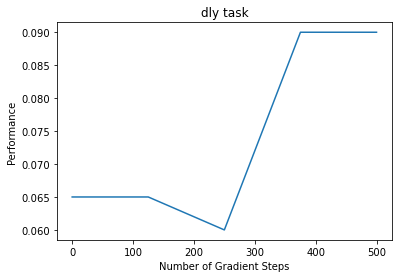

In [8]:
grad_steps = np.linspace(0,num_gradient_steps,len(perf_over_training))
plt.plot(grad_steps,perf_over_training)
plt.xlabel('Number of Gradient Steps')
plt.ylabel('Performance')
plt.title('dly task')